# Schedule TPC-DS 1 Dimensional Reduction (REP_HIST_SYSSTAT)

This notebook is dedicated to dataset profiling. In this notebook, dimensional reduction techniques will be implemented so as to categorize which features belay the most information to address the problem at hand - Workload Prediction. Due to the vast feature space which have been gathered during a workload's execution, manual techniques at determining which are most detrimental is not sufficient. 

Therefore the following work puts emphasis on automated techniques so as to determine out of the vast feature space which are most important to base future models upon. The proposed techniques will focus on each of the proposed four datasets:

* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* __REP_HIST_SYSSTAT__
* REP_VSQL_PLAN

Further more, dimensionality reduction will be covered from two different aspects. First, feature selection techniques will be implemented to elimate features which are considered unimportant using entropy based measures. Once a number of 'static' features are pruned from the original dataset, the remainding features are then processed through a Singular Value Decomposition process, where in features are reduced through PCA (Principal Compoenent Analysis).

In [21]:
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import r2_score

### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment

* tpcds - Schema upon which to operate test
* debug_mode - Determines whether to plot graphs or not, useful for development purposes
* low_quartile_limit - Lower Quartile threshold to detect outliers
* upper_quartile_limit - Upper Quartile threshold to detect outliers
* test_split - Denotes which Data Split to operate under when it comes to training / validation
* nrows - Number of rows to read from csv file
* top_n_features - Number of top features to focus on
* parallel_degree - Number of parallel threads to train models with

In [22]:
# Experiment Config
tpcds='TPCDS1'
debug_mode=False 
low_quartile_limit = .001
upper_quartile_limit = .999
test_split=.2
nrows=None
top_n_features=200
parallel_degree=6

### Read data from file into Pandas Dataframes

In [23]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path,nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)
print(rep_hist_sysstat_df.columns)
print('\n\nTable [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Index(['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'STAT_ID', 'STAT_NAME', 'VALUE',
       'CON_DBID', 'CON_ID', 'STARTUP_TIME', 'BEGIN_INTERVAL_TIME',
       'END_INTERVAL_TIME', 'FLUSH_ELAPSED', 'SNAP_LEVEL', 'ERROR_COUNT',
       'SNAP_FLAG', 'SNAP_TIMEZONE'],
      dtype='object')


Table [REP_HIST_SYSSTAT] - (10000, 16)


# Dataset Description

The correlation of resources consumed (y) per snapshot (X) define our feature space. Since the objective here is to attempt to predict what resources will be incurred ahead of time, the problem can be defined as a number of questions:

* Q: What resources can I predict to be in usage at point N in time?
* Q: What resources should I be predicting that accurately portray a schedule's workload?
* Q: What knowledge/data do I have ahead of time which I can use to base my predictions off?

Due to the vast feature space in the available metrics monitored and captured during a workload's execution, it is important to rank which attribute is most beneficial than others. Additionally, it is important to analyze such features individually, and considerate of other features in two types of analysis:

* Univariate Analysis
* Multivariate Analysis

Furthermore, multiple types of feature ranking / analysis techniques ara available, amongst which will be considered:

* Filter Methods
* Wrapper Methods
* Embedded Methods

# Data Preprocessing

We apply a number of preprocessing techniques to the presented dataframes, particularly to normalize and/or scale feature vectors into a more suitable representation for downstream estimators:

Relative Links:
* http://scikit-learn.org/stable/modules/preprocessing.html
* https://machinelearningmastery.com/improve-model-accuracy-with-data-pre-processing/
* https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

### Table Pivots

To better handle the following table, a number of table pivots are made on tables:
* rep_hist_sysstat

In [24]:
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
print(rep_hist_sysstat_df.columns)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
print("REP_HIST_SYSSTAT_DF Shape: " + str(rep_hist_sysstat_df.shape))

# Refreshing columns with pivoted columns
def convert_list_to_upper(col_list):
    """
    Takes a string and converts elements to upper
    """
    upper_col_list = []
    for col in col_list:
        upper_col_list.append(col.upper())
    return upper_col_list

rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# DF Shape
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Index(['SNAP_ID', 'ADG global flush', 'ADG parselock X get attempts',
       'ADG parselock X get successes', 'BA au bytes allocated',
       'BA bytes for file maps', 'BA bytes read from disk',
       'BA bytes read from flash', 'BA count - borrowed from other node',
       'BA count - cache denied',
       ...
       'user logouts cumulative', 'user rollbacks',
       'very large tracked transactions', 'workarea executions - multipass',
       'workarea executions - onepass', 'workarea executions - optimal',
       'workarea memory allocated', 'write clones created for recovery',
       'write clones created in background',
       'write clones created in foreground'],
      dtype='object', name='STAT_NAME', length=1179)
REP_HIST_SYSSTAT_DF Shape: (9, 1179)
Table [REP_HIST_SYSSTAT] - (9, 1179)


### Checking for NaN Values

Checking dataframes for potential missing values/data:

In [25]:
def get_na_columns(df):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in df.columns:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print("Table REP_HIST_SYSSTAT: " + str(get_na_columns(df=rep_hist_sysstat_df)) + "\n\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

Table REP_HIST_SYSSTAT: ['CCURSOR + SQL AREA EVICTED', 'CLI FLSTASK CREATE', 'CLI BYTES FLS TO EXT', 'CLI BYTES FLS TO TABLE', 'CLUSTERWIDE GLOBAL TRANSACTIONS', 'CLUSTERWIDE GLOBAL TRANSACTIONS SPANNING RAC NODES', 'DDL STATEMENTS PARALLELIZED', 'DFO TREES PARALLELIZED', 'DML STATEMENTS PARALLELIZED', 'DX/BB ENQUEUE LOCK BACKGROUND GET TIME', 'DX/BB ENQUEUE LOCK BACKGROUND GETS', 'DX/BB ENQUEUE LOCK FOREGROUND REQUESTS', 'DX/BB ENQUEUE LOCK FOREGROUND WAIT TIME', 'EHCC ANALYZE CUS DECOMPRESSED', 'EHCC ANALYZER CALLS', 'EHCC ARCHIVE CUS COMPRESSED', 'EHCC ARCHIVE CUS DECOMPRESSED', 'EHCC ATTEMPTED BLOCK COMPRESSIONS', 'EHCC BLOCK COMPRESSIONS', 'EHCC CU ROW PIECES COMPRESSED', 'EHCC CUS COMPRESSED', 'EHCC CUS DECOMPRESSED', 'EHCC CUS ALL ROWS PASS MINMAX', 'EHCC CUS NO ROWS PASS MINMAX', 'EHCC CUS SOME ROWS PASS MINMAX', 'EHCC CHECK CUS DECOMPRESSED', 'EHCC COLUMNS DECOMPRESSED', 'EHCC COMPRESSED LENGTH COMPRESSED', 'EHCC COMPRESSED LENGTH DECOMPRESSED', 'EHCC CONVENTIONAL DMLS', 'EHCC

### Label Encoding

Since this experiment deals with prediction of upcoming SQL_IDs, respectice SQL_ID strings need to labelled as a numeric representation. Label Encoder will be used here to convert SQL_ID's into a numeric format, which are in turn used for training. Evaluation (achieved predictions) is done so also in numeric format, at which point the label encoder is eventually used to decode back the labels into the original, respetive SQL_ID representation.

This section of the experiment additionally converts the targetted label into a binarized version of the previous achieved categorical numeric values.

* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [26]:
class LabelEncoder:
    """
    Scikit Label Encoder was acting up with the following error whilst using the transform function, even though I tripled 
    checked that the passed data was exactly the same as the one used for training:
    
    * https://stackoverflow.com/questions/46288517/getting-valueerror-y-contains-new-labels-when-using-scikit-learns-labelencoder
    
    So I have rebuilt a similar functionality to categorize my data into numeric digits, as the LabelEncoder is supposed to do.
    """
    #
    def __init__(self):
        self.__class_map = {}
        self.__integer_counter = 0
    #
    def fit(self, X):
        """
        :param - X: python list
        """
        for val in X:
            if val not in self.__class_map:
                self.__class_map[val] = self.__integer_counter
                self.__integer_counter += 1
    #
    def transform(self, X):
        """
        param - X: python list
        """
        encoded_map = []
        for val in X:
            if val in self.__class_map:
                value = self.__class_map[val]
                encoded_map.append(value)
            else:
                raise ValueError('Label Mismatch - Encountered a label which was not trained on.')
        return encoded_map
    #
    def get_class_map(self):
        """
        Returns original classes as a list
        """
        class_map = []
        for key, value in self.__class_map.items():
            class_map.append(key)
        return class_map
    #
    def get_encoded_map(self):
        """
        Returns class encodings as a list
        """
        encoded_map = []
        for key, value in self.__class_map.items():
            encoded_map.append(value)
        return encoded_map

print('-'*10 + 'BEFORE' + '-'*10)
print(rep_hist_sysstat_df.shape)
print(rep_hist_sysstat_df.head(10))

for col in rep_hist_sysstat_df.columns:
    first_ten_vals = rep_hist_sysstat_df[col].iloc[0:nrows]
    try:
        for val in first_ten_vals:
            val = int(val)
        continue  # If value is type casted successfully, then move on to the next value since it doesn't require label encoding
    except ValueError:
        le = LabelEncoder()  # Encode column with labels
        val_list = rep_hist_sysstat_df[col].tolist()
        le.fit(val_list)
        transformed_map = le.transform(val_list)
        rep_hist_sysstat_df[col] = pd.DataFrame(transformed_map, columns=[col])

print('-'*10 + 'AFTER' + '-'*10)
print(rep_hist_sysstat_df.shape)
print(rep_hist_sysstat_df.head(10))

----------BEFORE----------
(9, 1179)
STAT_NAME  SNAP_ID  ADG GLOBAL FLUSH  ADG PARSELOCK X GET ATTEMPTS  \
0            43414               0.0                           0.0   
1            43415               0.0                           0.0   
2            43416               0.0                           0.0   
3            43417               0.0                           0.0   
4            43418               0.0                           0.0   
5            43419               0.0                           0.0   
6            43420               0.0                           0.0   
7            43421               0.0                           0.0   
8            43422               0.0                           0.0   

STAT_NAME  ADG PARSELOCK X GET SUCCESSES  BA AU BYTES ALLOCATED  \
0                                    0.0                    0.0   
1                                    0.0                    0.0   
2                                    0.0                    0

### Checking for Negative Values

A function which retrieves a count per column for nay negative values it might contain

In [27]:
class NegativeHandler:
    """
    This class contains logic pertaining to handling of negative values.
    """

    def __init__(self, df):
        """
        Class constructor.
        :param df:      (Pandas) Data matrix containing data.
        :return: None
        """
        self.__df = df
        self.__headers = df.columns

    def count_neg_df(self):
        """
        Return columns with respective negative value count.
        :return: (List) Retrieves list of row positions denoting negative occurance.
        """
        neg_list = []
        for head in self.__headers:
            count = 0
            try:
                count = sum(n < 0 for n in self.__df[head].values.flatten())
            except Exception:
                pass
                #print('Non numeric column [' + head + ']')
            if count > 0:
                neg_list.append([head,count])
        return neg_list

    def fill_neg(self):
        """
        Sets any data anomilies resulting in negative values to 0
        :return: (Pandas) Dataframe with ammended negative values.
        """
        headers = self.count_neg_df()
        df = self.__df
        for head in headers:
            try:
                df[df[head] < 0] = 0
            except Exception:
                pass
                #print('Non numeric column [' + head + ']')
        return df

nh = NegativeHandler(df=rep_hist_sysstat_df)

# Check For Negative Values within dataframes
print('---------------WITH NEGATIVE VALUES---------------')
print("Table REP_HIST_SYSSTAT: " + str(nh.count_neg_df()) + "\n\n")

# Replace Negative Values with a minimal threshold of 0
rep_hist_sysstat_df = nh.fill_neg()

# Check For Negative Values within dataframes
print('\n\n---------------WITHOUT NEGATIVE VALUES---------------')
print("Table REP_HIST_SYSSTAT: " + str(nh.count_neg_df()) + "\n\n")

---------------WITH NEGATIVE VALUES---------------
Table REP_HIST_SYSSTAT: []




---------------WITHOUT NEGATIVE VALUES---------------
Table REP_HIST_SYSSTAT: []




### Redundant Feature Removal

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [28]:
class DropFlatline:

    @staticmethod
    def drop_flatline_columns(df):
        """
        This function removes columns with a flat standard deviation of 0.
        """
        columns = df.columns
        flatline_features = []
        for i in range(len(columns)):
            try:
                std = df[columns[i]].std()
                if std == 0:
                    flatline_features.append(columns[i])
                    print('Dropping feature [' + columns[i]  + ']')
            except:
                pass
        #
        #print('Features which are considered flatline:\n')
        #for col in flatline_features:
        #    print(col)
        print('\nShape before changes: [' + str(df.shape) + ']')
        df = df.drop(columns=flatline_features)
        print('Shape after changes: [' + str(df.shape) + ']')
        print('Dropped a total [' + str(len(flatline_features)) + ']')
        return df

rep_hist_sysstat_df = DropFlatline.drop_flatline_columns(df=rep_hist_sysstat_df)

Dropping feature [ADG GLOBAL FLUSH]
Dropping feature [ADG PARSELOCK X GET ATTEMPTS]
Dropping feature [ADG PARSELOCK X GET SUCCESSES]
Dropping feature [BA AU BYTES ALLOCATED]
Dropping feature [BA BYTES FOR FILE MAPS]
Dropping feature [BA BYTES READ FROM DISK]
Dropping feature [BA BYTES READ FROM FLASH]
Dropping feature [BA COUNT - BORROWED FROM OTHER NODE]
Dropping feature [BA COUNT - CACHE DENIED]
Dropping feature [BA COUNT - CACHE MISS]
Dropping feature [BA COUNT - SEARCHED IN PB]
Dropping feature [BA COUNT - SHORT CIRCUIT IN IDN]
Dropping feature [BA COUNT - TOTAL ALLOCATION REQUESTS]
Dropping feature [BA COUNT - UNABLE TO SHORT CIRCUIT IN IDN]
Dropping feature [BA COUNT WHEN 10% OF BUCKETS IN PB]
Dropping feature [BA COUNT WHEN 25% OF BUCKETS IN PB]
Dropping feature [BA COUNT WHEN 50% OF BUCKETS IN PB]
Dropping feature [BA COUNT WHEN 75% OF BUCKETS IN PB]
Dropping feature [BA COUNT WHEN 90% OF BUCKETS IN PB]
Dropping feature [BA FILE BYTES ALLOCATED]
Dropping feature [BA FILE BYTES 

Dropping feature [IM REPOPULATE ACCUMULATED TIME (MS)]
Dropping feature [IM REPOPULATE BLOCKS INVALID]
Dropping feature [IM REPOPULATE BYTES FROM STORAGE]
Dropping feature [IM REPOPULATE BYTES IN-MEMORY DATA]
Dropping feature [IM REPOPULATE BYTES UNCOMPRESSED DATA]
Dropping feature [IM REPOPULATE ROWS]
Dropping feature [IM REPOPULATE SEGMENTS]
Dropping feature [IM REPOPULATE SEGMENTS REQUESTED]
Dropping feature [IM REPOPULATE TRANSACTIONS ACTIVE]
Dropping feature [IM REPOPULATE TRANSACTIONS CHECK]
Dropping feature [IM REPOPULATE UNDO RECORDS APPLIED]
Dropping feature [IM REPOPULATE UNDO SEGHEADER ROLLBACK]
Dropping feature [IM SCAN CUS CLEANOUT]
Dropping feature [IM SCAN CUS COLUMN NOT IN MEMORY]
Dropping feature [IM SCAN CUS COLUMNS ACCESSED]
Dropping feature [IM SCAN CUS COLUMNS DECOMPRESSED]
Dropping feature [IM SCAN CUS COLUMNS THEORETICAL MAX]
Dropping feature [IM SCAN CUS FAILED TO REGET PIN]
Dropping feature [IM SCAN CUS INVALID]
Dropping feature [IM SCAN CUS INVALID (ALL ROWS A

## Visualizing Feature Distribution & Skewness

In order to decide between a normalization strategy, it is important to understand the underlying data spread. Understanding of dataset mean, variance, skewness on a per column/feature basis helps determine whether a standardization or normalization strategy should be utilized on the datasets.

### Plotting Data Distribution

To better decide which normalization technique ought to be utilized for the technique at hand, a number of feature columns will be plotted as histograms to better convey the distribution spread.

In [29]:
class Visualizer:
    """
    This class contains a number of methods dedicated to plotting the underlying data.
    """
    def __init__(self, df=None, tpc_type=None, table=None):
        """
        Constructor method.
        :param df:             (Pandas) Data matrix.
        :param tpc_type:       (String) TPC type, used for plot title purposes.
        :param table:          (String) Denotes which table is being access, used for plot title/label purposes.
        :return: None
        """
        self.__df = df
        self.__tpc_type = tpc_type
        self.__table = table
        
    def plot_hist(self, bin_size=10, feature_column=None):
        """
        Plots histogram distribution, split into a number of buckets.
        :param bin_size: (Integer) Denotes number of histogram buckets to split data into.
        :param feature_column: (String) Denotes which column to plot.
        :return: None
        """
        df = self.__df

        try:
            df['SNAP_ID'] = df['SNAP_ID'].astype(float)
            df[feature_column] = df[feature_column].astype(float)

            max_val = df[feature_column].max()
            start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())

            df[feature_column].hist(bins=10,figsize=(12,8))
            plt.ylabel(feature_column)
            plt.xlabel('Bin Ranges Of ' + str(int(max_val/bin_size)))
            plt.title(self.__tpc_type + ' Table ' + self.__table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
            plt.show()
        except Exception:
            print('Could not plot column: ' + feature_column)

    def plot_scatter(self, feature_column=None):
        """
        Plots scatter plots vs SNAP_ID.
        :param feature_column: (String) Denotes which column to plot.
        :return: None
        """
        df = self.__df

        try:
            df['SNAP_ID'] = df['SNAP_ID'].astype(int)
            df[feature_column] = df[feature_column].astype(int)
            start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())

            df.plot.scatter(x='SNAP_ID',
                            y=feature_column,
                            figsize=(12,8))
            plt.ylabel(feature_column)
            plt.xlabel('SNAP ID')
            plt.title(self.__tpc_type + ' Table ' + self.__table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
            plt.show()
        except Exception:
            print('Could not plot column: ' + feature_column)

    def plot_boxplot(self, feature_column=None):
        """
        Plots quartile plots to estimate mean and sigma (std dev).
        :param feature_column: (String) String denoting feature column. Overrides parameter used in class constructor.
        :return: None
        """
        df = self.__df

        try:
            df[feature_column] = df[feature_column].astype(float)
            df.boxplot(column=feature_column, figsize=(12,8), grid=True)
            plt.title(self.__tpc_type + ' ' + str(feature_column))
            plt.show()
        except ValueError:
            print('Could not plot column: ' + feature_column)
            
vis = Visualizer(df=rep_hist_sysstat_df, 
                 tpc_type=tpcds, 
                 table='rep_hist_sysstat')

if debug_mode is False:
    
    # Plotting Histograms of data distribution
    for header in rep_hist_sysstat_df.columns:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS HISTOGRAM')
        vis.plot_hist(bin_size=10, feature_column=header)
    
    # Plotting Scatter Plots of data distribution
    for header in rep_hist_sysstat_df.columns:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS SCATTER')
        vis.plot_scatter(feature_column=header)

### Outlier Handling

https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

As can be appreciated from the previous plots, data is heavily skewed on particular (smallest) bins. This skew in the plotted histograms is a result of data point outliers - these need to be evaluated and removed if neccessary.

Following the 3 Standard Deviation Rule, we can categorize our dataset into subsets consisting of the following ranges:
* 0     - 68.27%
* 68.28 - 95.45%
* 95.46 - 99.73%
* 99.74 - 100%

It should be mentioned, that given the time series nature of the dataset, it is not a safe assumption to ignore outliers. By training respective models on outlier insensitive dataset, we would invite a potential problem, which risks blinding any models we train to future predicted spikes of activity.

In [30]:
class OutlierHandling:
    """
    This class handles outlier detection and removal methods.
    """
    def __init__(self, df, low_quartile_limit=.01,upper_quartile_limit=.99):
        """
        Constructor method.
        :param df:                   (Pandas) Dataframe consisting of input features to be pruned of outliers.
        :param low_quartile_limit:   (Float) Lower percentage threshold for removal of outliers.
        :param upper_quartile_limit: (Float) Upper percentage threshold for removal of outliers.
        :return: None
        """
        self.__df = df
        self.__low_quartile_limit = low_quartile_limit
        self.__upper_quartile_limit = upper_quartile_limit
        self.__headers= df.columns
        
    def get_outliers(self):
        """
        Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
        :return: (List) A list denoting row positions of detected outliers.
        """
        outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
        df = self.__df
        for header in self.__headers:
            try:
                df[header] = df[header].astype(float)
                q = df[header].quantile(self.__upper_quartile_limit)
                series_row = (df[df[header] > q].index)
                for id in list(np.array(series_row)):
                    outlier_rows.append([header,id])
                q = df[header].quantile(self.__low_quartile_limit)
                series_row = (df[df[header] < q].index)
                for id in list(np.array(series_row)):
                    outlier_rows.append([header,id])
            except Exception as e:
                print(str(e))

        unique_ids = []
        unique_outlier_rows = []

        for col, rowid in outlier_rows:
            if rowid not in unique_ids:
                unique_outlier_rows.append([col,rowid])
                unique_ids.append(rowid)
        return unique_outlier_rows

    def remove_outliers(self):
        """
        Remove rows which are considered outliers within the dataset, determined by :quartile_limit (99%).
        :return: (Pandas) Dataframe with pruned outliers.
        """
        df = self.__df
        length_before = len(df)
        outliers_index = []
        for header in self.__headers:
            try:
                df[header] = df[header].astype(float)
                q = df[header].quantile(self.__upper_quartile_limit)
                outliers_index.append(list(np.array(df[df[header] > q].index)))
                q = df[header].quantile(self.__low_quartile_limit)
                outliers_index.append(list(np.array(df[df[header] < q].index)))
            except Exception as e:
                print(str(e))
        #flat_outliers_index = [item for sublist in l for item in outliers_index]
        flat_outliers_index = [item for sublist in outliers_index for item in sublist]
        outliers_index = list(set(flat_outliers_index))
        df = df.drop(outliers_index)
        return df
    
oh = OutlierHandling(df=rep_hist_sysstat_df,
                     upper_quartile_limit=upper_quartile_limit,
                     low_quartile_limit=low_quartile_limit)

#Printing outliers to screen
outliers = oh.get_outliers()

# Printing dataframe before adjustments
print('\n\nDATAFRAMES WITH OUTLIERS')
print(rep_hist_sysstat_df.shape)
print('----------------------------')

rep_hist_sysstat_df_outliers = oh.get_outliers()
print('\n\nOUTLIERS')
print(len(rep_hist_sysstat_df_outliers))
print('----------------------------')

# Dropping Outliers
rep_hist_sysstat_df_pruned = oh.remove_outliers()
print('\n\nDATAFRAMES WITHOUT OUTLIERS')
print(rep_hist_sysstat_df_pruned.shape)



DATAFRAMES WITH OUTLIERS
(9, 301)
----------------------------


OUTLIERS
6
----------------------------


DATAFRAMES WITHOUT OUTLIERS
(3, 301)


### Plotting data distribution without outliers

Plotting metrics against SNAP_ID, without outliers.

In [31]:
vis = Visualizer(df=rep_hist_sysstat_df_pruned, 
                 tpc_type=tpcds, 
                 table='rep_hist_sysstat')

if debug_mode is False:
    
    # Plotting Histograms without Outliers
    for header in rep_hist_sysstat_df_pruned.columns:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED HISTOGRAM')
        vis.plot_hist(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds, table='rep_hist_sysstat', feature_column=header, bin_size=10)
    
    # Plotting Scatter Plots without Outliers
    for header in rep_hist_sysstat_df_pruned.columns:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED SCATTER')
        vis.plot_scatter(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds,table='rep_hist_sysstat',feature_column=header)

### Dropping Redundant Columns

Dropping redundant columns which are not detrimental to the task at hand (NB: This is only the first steps towards feature selection. This step ensures that specific columns which are SURELY not useful are dropped ahead of time).

http://benalexkeen.com/feature-scaling-with-scikit-learn/

Based on the above plots, one can argue that the data distribution is uneven, and does not correlate to any particular pattern. A normalization approach (MinMaxScaling and/or RobustScaling) to the presented dataset is a more likely candidate than standardizing of the presented dataset. 

Reasons behind normalizing the dataset rather than standardizing, is due to the vast standard deviations from the mean for several feature columns.

In [32]:
class NonNumericStrip:
    """
    This class contains a method dedicated to feature removing if they contain non-numeric data
    """
    @staticmethod
    def remove_non_numeric_columns(df):
        """
        Accepts data matrix, and returns another matrix with stripped columns containing non-numeric data.
        :param df: (Pandas) Data matrix
        :return: (Pandas) Data matrix
        """
        print('-'*10 + 'Before' + '-'*10)
        print(df.columns)
        col_list = []
        for col in df.columns:
            try:
                df[col] = df[col].astype(float)
                col_list.append(col)
            except ValueError:
                print('Column ' + str(col) + ' contains non numeric data')
        df = df[col_list]
        print('-'*10 + 'After' + '-'*10)
        print(df.columns)
        return df
rep_hist_sysstat_df_pruned = NonNumericStrip.remove_non_numeric_columns(df=rep_hist_sysstat_df_pruned)

----------Before----------
Index(['SNAP_ID', 'BATCHED IO (BOUND) VECTOR COUNT',
       'BATCHED IO (FULL) VECTOR COUNT', 'BATCHED IO (SPACE) VECTOR COUNT',
       'BATCHED IO BLOCK MISS COUNT', 'BATCHED IO BUFFER DEFRAG COUNT',
       'BATCHED IO DOUBLE MISS COUNT', 'BATCHED IO SAME UNIT COUNT',
       'BATCHED IO SINGLE BLOCK COUNT', 'BATCHED IO SLOW JUMP COUNT',
       ...
       'USER CALLS', 'USER COMMITS', 'USER LOGONS CUMULATIVE',
       'USER LOGOUTS CUMULATIVE', 'USER ROLLBACKS',
       'WORKAREA EXECUTIONS - MULTIPASS', 'WORKAREA EXECUTIONS - ONEPASS',
       'WORKAREA EXECUTIONS - OPTIMAL', 'WORKAREA MEMORY ALLOCATED',
       'WRITE CLONES CREATED IN FOREGROUND'],
      dtype='object', name='STAT_NAME', length=301)
----------After----------
Index(['SNAP_ID', 'BATCHED IO (BOUND) VECTOR COUNT',
       'BATCHED IO (FULL) VECTOR COUNT', 'BATCHED IO (SPACE) VECTOR COUNT',
       'BATCHED IO BLOCK MISS COUNT', 'BATCHED IO BUFFER DEFRAG COUNT',
       'BATCHED IO DOUBLE MISS COUNT',

### Dataset Consolidation

Grouping datasets on SNAP_ID

In [33]:
print("REP_HIST_SYSSTAT shape before transformation: " + str(rep_hist_sysstat_df_pruned.shape))
rep_hist_sysstat_df_pruned = rep_hist_sysstat_df_pruned[rep_hist_sysstat_df_pruned['SNAP_ID'] > 0]

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_sysstat_df_pruned = rep_hist_sysstat_df_pruned.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df_pruned.reset_index(inplace=True)

print("REP_HIST_SYSSTAT shape after transformation: " + str(rep_hist_sysstat_df_pruned.shape))

REP_HIST_SYSSTAT shape before transformation: (3, 301)
REP_HIST_SYSSTAT shape after transformation: (3, 301)


### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [34]:
class Normalizer:

    @staticmethod
    def robust_scaler(dataframe):
        """
        Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
        normalization of values.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.robust_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def minmax_scaler(dataframe):
        """
        Normalize df using min-max ranges for normalization method
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.minmax_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def normalize(dataframe):
        """
        The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.normalize(dataframe.values)
        return pd.DataFrame(X, columns=headers)

print('------------------BEFORE------------------')
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned.shape)
print('\n')
#print(rep_hist_snapshot_df_pruned.head())
#
# ROBUST SCALER
# rep_hist_sysstat_df_pruned_norm = Normalizer.robust_scaler(dataframe=rep_hist_sysstat_df_pruned)
#
# MINMAX SCALER
rep_hist_sysstat_df_pruned_norm = Normalizer.minmax_scaler(dataframe=rep_hist_sysstat_df_pruned)
#
# NORMALIZER
#rep_hist_sysstat_df_pruned_norm = Normalizer.normalize(dataframe=rep_hist_sysstat_df_pruned)

print('\n\n------------------AFTER------------------')
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned_norm.shape)
print('\n\n')
print('\n\nREP_HIST_SYSSTAT')
print(rep_hist_sysstat_df_pruned_norm.head())

------------------BEFORE------------------
------------------REP_HIST_SYSSTAT------------------
(3, 301)




------------------AFTER------------------
------------------REP_HIST_SYSSTAT------------------
(3, 301)





REP_HIST_SYSSTAT
STAT_NAME   SNAP_ID  BATCHED IO (BOUND) VECTOR COUNT  \
0          0.000000                              0.0   
1          0.666667                              1.0   
2          1.000000                              1.0   

STAT_NAME  BATCHED IO (FULL) VECTOR COUNT  BATCHED IO (SPACE) VECTOR COUNT  \
0                                     0.0                              0.0   
1                                     1.0                              0.0   
2                                     1.0                              0.0   

STAT_NAME  BATCHED IO BLOCK MISS COUNT  BATCHED IO BUFFER DEFRAG COUNT  \
0                             0.000000                             0.0   
1                             0.999751                             1.0   
2    

### Split Features / Labels

Split the data frame into features and Labels (SNAP_ID)

In [35]:
y_labels = rep_hist_sysstat_df_pruned['SNAP_ID']
del rep_hist_sysstat_df_pruned_norm['SNAP_ID']

# Filter Methods

* https://machinelearningmastery.com/feature-selection-machine-learning-python/

Filter methods allow for the univariate analysis of features. Particularly, the following statistical methods have been considered and dismissed as explained below:

* Information Gain - Data at hand is continous by nature, whilst MI is usually applicable against discrete values / binned labels.
* Pearson Correlation Coefficient - Applicable to data with linear distributions, which is not the case for the majority of the presented features.

In [36]:
class FeatureImportance:
    """
    This class is dedicated to containing methods related to feature ranking. Features are ranked exclusively, or mutually with
    repsect to other features.
    """
    @staticmethod
    def chi2_test(top_n_features=30, X_df=None, y_df=None, table=None):
        """
        Carries out a chi squared test on passed X,y dataframes, selecting top N features ranked by highest scoring.
        :param top_n_features: (Integer) Denotes number of top features to plot.
        :param x_df:           (Pandas) Pandas feature matrix.
        :param y_df:           (Pandas) Pandas label matrix.
        :param table:          (String) Denotes which table is being operated on.
        :return: None
        """
        headers = X_df.columns
        X_df = X_df.values
        y_df = y_df.values
        chi2_selector = SelectKBest(score_func=chi2, k=top_n_features)
        X_kbest = chi2_selector.fit_transform(X_df, y_df)
        print('\n\nTable [' + table.upper() + ']')
        print('Original number of features: ' + str(X_df.shape[1]))
        print('Reduced number of features: ' + str(X_kbest.shape[1]) + "\n")
        outcome = chi2_selector.get_support()

        scoring_sheet = []
        for i in range(0,len(headers)-1):
            if outcome[i]:
                scoring_sheet.append([headers[i],chi2_selector.scores_[i]])

        scoring_sheet = sorted(scoring_sheet, key=itemgetter(1), reverse=True)
        [print('Feature [' + str(row) + '] with score [' + str(score) + ']') for row, score in scoring_sheet[:top_n_features]]

        scoring_sheet = pd.Series((v[1] for v in scoring_sheet[:top_n_features]) )
        scoring_sheet[:top_n_features].plot.bar()
        
        FeatureImportance.__plot_metrics(ylabel='CHI2 RANKING',
                                         xlabel='FEATURES',
                                         title='Features Ranked By Chi2 Scoring')
      
    @staticmethod
    def rfr_ranking(X_df=None, y_df=None, top_n_features=30, parallel_degree=1):
        """
        Ranks features using a filter RFR method, and plots them in descending order (ranked by importance)
        :param x_df:           (Pandas) Pandas feature matrix.
        :param y_df:           (Pandas) Pandas label matrix.
        :param top_n_features: (Integer) Denotes number of top features to plot.
        :param parallel_degree:(Integer) Denotes model training parallel degree.
        :return: None
        """
        headers = X_df.columns
        X_df = X_df.values
        y_df = y_df.values
        rfr = RandomForestRegressor(n_estimators=X_df.shape[1]*10,  # Use 10* the number of features
                                    n_jobs=parallel_degree)
        rfr.fit(X_df, y_df)
        importances = pd.DataFrame({'feature':headers,
                                    'importance':np.round(rfr.feature_importances_,3)})
        importances = importances.sort_values('importance',ascending=False).set_index('feature')
        print(importances[:top_n_features])
        importances[:top_n_features].plot.bar()
        
        FeatureImportance.__plot_metrics(ylabel='RANDOM FOREST RANKING',
                                         xlabel='FEATURES',
                                         title='Features Ranked By Random Forest Scoring')
        
    @staticmethod
    def __plot_metrics(ylabel, xlabel, title):
        """
        Private method used to plot metrics for statistical feature evaluation
        :param ylabel: (String) ylabel title name.
        :param xlabel: (String) xlabel title name.
        :param title:  (String) plot title name.
        :return: None
        """
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.show()

### Chi2

Therefore, a likely candidate for a first univariate, filter test is a chi2 measure, between X labels 'SNAP_ID', and other output 'y' labels. NB: Due to chi2 requiring non-nagative values, a data normalization strategy was opted for (Refer to above cell).

The following cell computes the chi2 value for each feature pertaining in the following tables, in relation to the SNAP_ID feature:
* REP_HIST_SYSSTAT



Table [REP_HIST_SYSSTAT]
Original number of features: 300
Reduced number of features: 200

Feature [TEMP SPACE ALLOCATED (BYTES)] with score [2.000000000000001]
Feature [PREFETCH CLIENTS - DEFAULT] with score [2.0000000000000004]
Feature [TOTAL NUMBER OF SLOTS] with score [2.0000000000000004]
Feature [ROLLBACK CHANGES - UNDO RECORDS APPLIED] with score [1.9870864615705743]
Feature [SESSION UGA MEMORY] with score [1.9252348644702788]
Feature [SESSION PGA MEMORY MAX] with score [1.8603888897428713]
Feature [LOGONS CURRENT] with score [1.8300395256917001]
Feature [HEAP BLOCK COMPRESS] with score [1.820822271622697]
Feature [WORKAREA MEMORY ALLOCATED] with score [1.8146697737461577]
Feature [SESSION PGA MEMORY] with score [1.8085235828998059]
Feature [KTFB COMMIT REQ] with score [1.4761904761919364]
Feature [TRANSACTION ROLLBACKS] with score [1.4529411764688396]
Feature [REDO ORDERING MARKS] with score [1.440559440547292]
Feature [COMMIT SCN CACHED] with score [1.400000000006306]
Feature

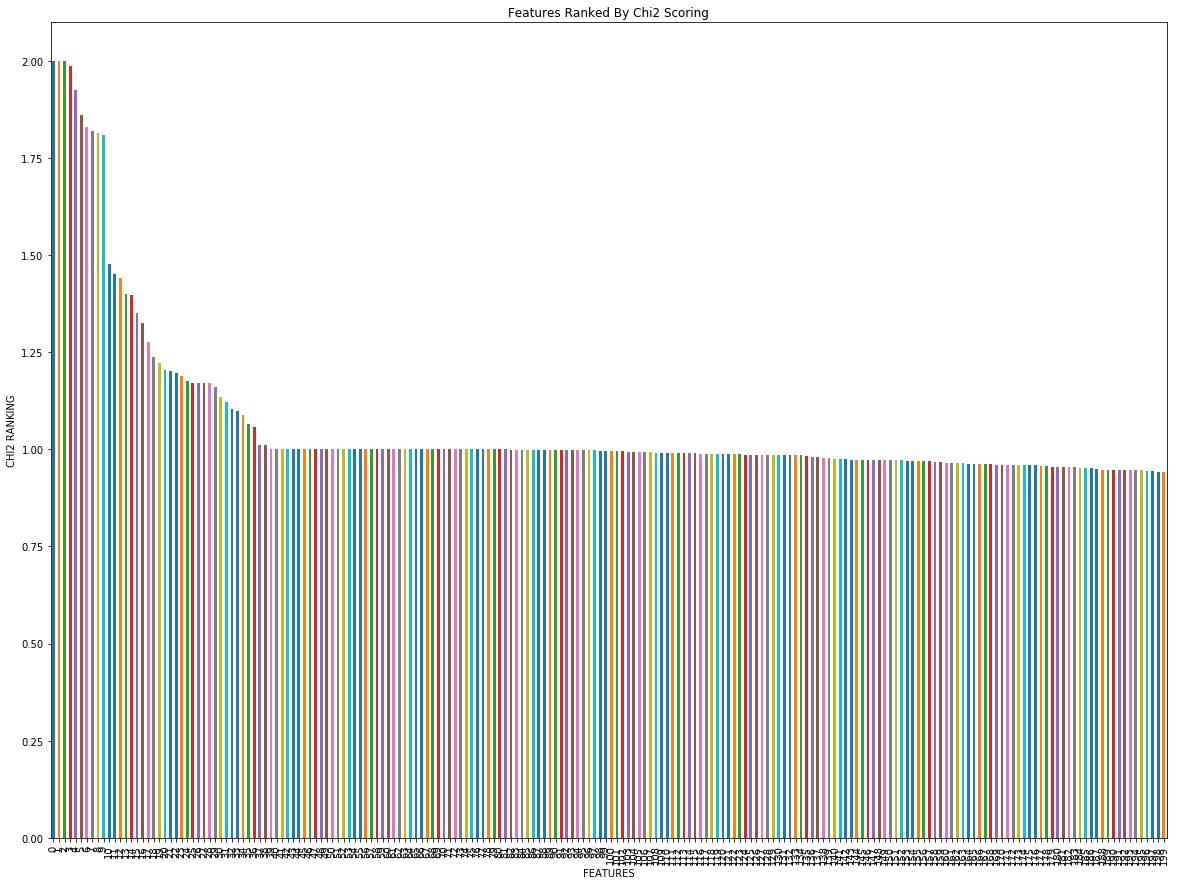

In [37]:
FeatureImportance.chi2_test(top_n_features=top_n_features, 
                            X_df=rep_hist_sysstat_df_pruned_norm, 
                            y_df=y_labels, 
                            table='REP_HIST_SYSSTAT')

### Random Forest Feature Importance

Calculating MI (Mutual Information) scoring between data matrix X (feature vectors) and target column y ('SNAP_ID') 

                                                 importance
feature                                                    
CONSISTENT GETS FROM CACHE                            0.010
BATCHED IO BUFFER DEFRAG COUNT                        0.009
HEAP SEGMENT ARRAY UPDATES                            0.008
IMU FLUSHES                                           0.008
PHYSICAL WRITE BYTES                                  0.008
HEATMAP BLKLEVEL FLUSHED TO BF                        0.008
CLI BG ATTEMPT FLUSH                                  0.008
PHYSICAL WRITE TOTAL MULTI BLOCK REQUESTS             0.008
ENQUEUE TIMEOUTS                                      0.008
TOTAL NUMBER OF SLOTS                                 0.007
REDO SUBSCN MAX COUNTS                                0.007
CPU USED WHEN CALL STARTED                            0.007
FILE IO SERVICE TIME                                  0.007
LEAF NODE 90-10 SPLITS                                0.007
PHYSICAL READS CACHE PREFETCH           

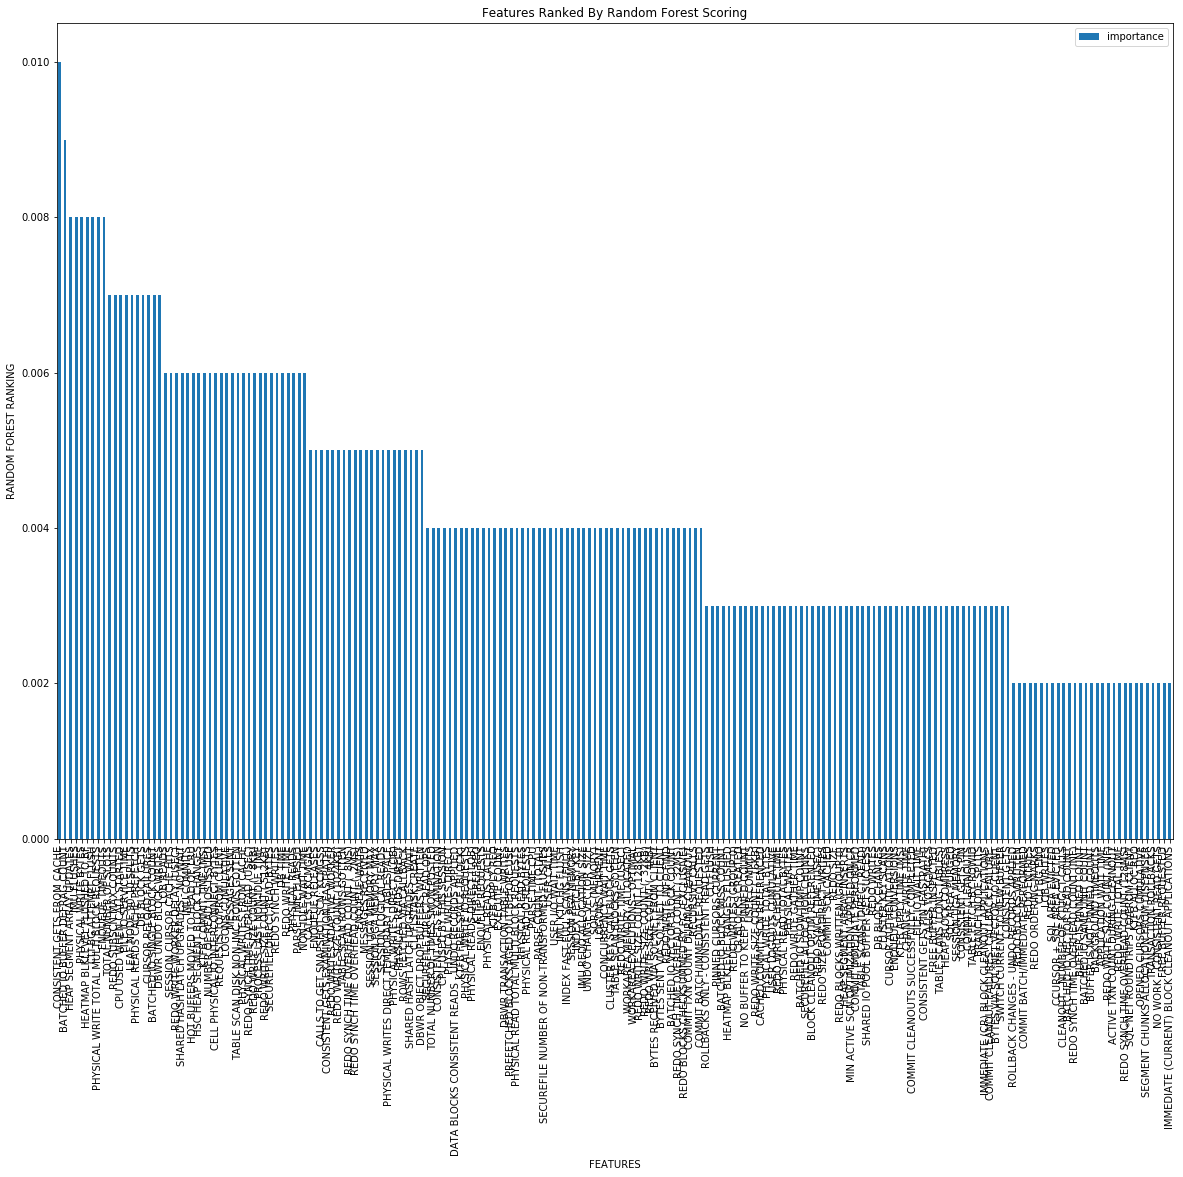

In [38]:
FeatureImportance.rfr_ranking(top_n_features=top_n_features,
                              X_df=rep_hist_sysstat_df_pruned_norm, 
                              y_df=y_labels, 
                              parallel_degree=parallel_degree)

### Wrapper Methods

Use a number of machine learning models to evaluate features together and rank by highest. The following machine learning models will be opted for:

* Random Forest Classifier
* Gradient Boosting

In a 'Brute-Fore' approach, these machine learning heuristics will strip away 1 feature at a time in a method referred to as 'Recursive Feature Elimination', and compare accuracy with every variable elimination. This allows the respective classifier to establish an optimum feature configuration with the highest accuracy score.

https://www.fabienplisson.com/choosing-right-features/

In [39]:
class EnsembleWrappers:
    """
    This class contains wrapper methods, which utilize ensemble methods to gauge feature pairings. Features are combined together
    and then stripped one at a time. Each feature combination is evaluated per feature count, so as to establish the optimum
    feature count cut off.
    """
    @staticmethod
    def rfr_wrapper(X_df=None, y_df=None, test_split=.4, table_name=None, top_n_features=10, parallel_degree=1):
        """
        Random Forest Regressor - Takes data matrix and target vector, and evaluates best combination of features 
        using an RFR model.
        :param x_df:           (Pandas) Pandas feature matrix.
        :param y_df:           (Pandas) Pandas label matrix.
        :param test_split:     (Float) Denotes training/testing data split.
        :param table_name:     (String) Denotes which table is being operated on.
        :param top_n_features: (Integer) Denotes number of top features to plot.
        :param parallel_degree:(Integer) Denotes model training parallel degree.
        :return: Model Scoring, for best feature combination count
        :return: Recommended feature count, as per best achieved score
        """
        X_df = X_df.values
        y_df = y_df.values

        val_op, optimum_features = 0, 0
        val_op = 0
        X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
        model = RandomForestRegressor(n_estimators=X_df.shape[1]*10,  # Use 10* the number of features
                                      n_jobs=parallel_degree)
        model.fit(X_train, y_train)

        # make predictions for test data and evaluate
        pred_y = model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        print("Table [" + table_name + "] RFR R2 Score: " + str(r2s))

        # fit model using each importance as a threshold
        print('Feature Importance\n' + str('-'*60))
        print(model.feature_importances_)
        print(str('-'*60))
        thresholds = np.sort(model.feature_importances_)
        feature_counts, feature_score = [],[]
        for thresh in thresholds:
            # selecting features using threshold
            selection = SelectFromModel(model, threshold=thresh, prefit=True)
            select_train_x = selection.transform(X_train)

            # training model
            selection_model = RandomForestRegressor(n_estimators=X_df.shape[1]*10,  # Use 10* the number of features
                                                    n_jobs=parallel_degree)
            selection_model.fit(select_train_x, y_train)

            # evaluating model
            select_test_x = selection.transform(X_test)
            pred_y = selection_model.predict(select_test_x)
            predictions = [round(value) for value in pred_y]
            r2s = r2_score(y_test, predictions)
            print("Thresh=" + str(thresh) + ", n=" + str(select_train_x.shape[1]) + ", R2 Score: " + str(r2s))
            if(r2s > val_op):
                val_op = r2s
                optimum_features = select_train_x.shape[1]

            # Add/Keep track of '[no of features','r2 score']
            feature_counts.append(select_train_x.shape[1])
            feature_score.append(r2s)

        # Plot feature count performance
        EnsembleWrappers.__plot_metrics(feature_counts=feature_counts,
                                        feature_score=feature_score,
                                        xlabel='Featuers',
                                        ylabel='R2 Score',
                                        title='Feature Pairing Performance')

        return val_op, optimum_features

    @staticmethod
    def gradient_boosting_wrapper(X_df=None, y_df=None, test_split=.4, table_name=None, top_n_features=10):
        """
        Gradient Boosting Regressor - Takes data matrix and target vector, and evaluates best combination of features 
        using a GBR model.
        :param x_df:           (Pandas) Pandas feature matrix.
        :param y_df:           (Pandas) Pandas label matrix.
        :param test_split:     (Float) Denotes training/testing data split.
        :param table_name:     (String) Denotes which table is being operated on.
        :param top_n_features: (Integer) Denotes number of top features to plot.
        :param parallel_degree:(Integer) Denotes model training parallel degree.
        :return: Model Scoring, for best feature combination count
        :return: Recommended feature count, as per best achieved score
        """
        X_df = X_df.values
        y_df = y_df.values
        val_op, optimum_features = 0, 0
        X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
        model = GradientBoostingRegressor(n_estimators=X_df.shape[1]*10)  # Use 10* the number of features
        model.fit(X_train, y_train)

        # make predictions for test data and evaluate
        pred_y = model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        print("Table [" + table_name + "] RFR R2 Score: " + str(r2s))
        #
        # fit model using each importance as a threshold
        print('Feature Importance\n' + str('-'*60))
        print(model.feature_importances_)
        print(str('-'*60))
        thresholds = np.sort(model.feature_importances_)
        feature_counts, feature_score = [],[]
        for thresh in thresholds:
            # selecting features using threshold
            selection = SelectFromModel(model, threshold=thresh, prefit=True)
            select_train_x = selection.transform(X_train)

            # training model
            selection_model = GradientBoostingRegressor(n_estimators=X_df.shape[1]*10)  # Use 10* the number of features
            selection_model.fit(select_train_x, y_train)

            # evaluating model
            select_test_x = selection.transform(X_test)
            pred_y = selection_model.predict(select_test_x)
            predictions = [round(value) for value in pred_y]
            r2s = r2_score(y_test, predictions)
            print("Thresh=" + str(thresh) + ", n=" + str(select_train_x.shape[1]) + ", R2 Score: " + str(r2s))
            if(r2s > val_op):
                val_op = r2s
                optimum_features = select_train_x.shape[1]

            # Add/Keep track of '[no of features','r2 score']
            feature_counts.append(select_train_x.shape[1])
            feature_score.append(r2s)

        # Plot feature count performance
        EnsembleWrappers.__plot_metrics(feature_counts=feature_counts,
                                        feature_score=feature_score,
                                        xlabel='Featuers',
                                        ylabel='R2 Score',
                                        title='Feature Pairing Performance')

        return val_op, optimum_features
    
    @staticmethod
    def __plot_metrics(feature_counts, feature_score, ylabel, xlabel, title):
        """
        Private method used to plot metrics for statistical feature evaluation
        :param feature_counts: (List) List of feature combination counts per achieved score.
        :param feature_score:  (List) List of feature scores per combination.
        :param ylabel:         (String) ylabel title name.
        :param xlabel:         (String) xlabel title name.
        :param title:          (String) plot title name.
        :return: None
        """
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.plot(feature_counts, feature_score)
        plt.show()

### Random Forest Wrapper (Feature Combination)  (Regression)

Utilizes an ensemble Random Forest method to gauge different feature combination/counts.

Table [REP_HIST_SYSSTAT] RFR R2 Score: 1.0
Feature Importance
------------------------------------------------------------
[0.    0.003 0.    0.001 0.002 0.002 0.001 0.001 0.001 0.    0.    0.001
 0.002 0.    0.002 0.001 0.002 0.    0.    0.002 0.001 0.003 0.001 0.001
 0.    0.    0.002 0.002 0.003 0.    0.    0.002 0.004 0.    0.001 0.
 0.001 0.002 0.001 0.    0.    0.002 0.006 0.002 0.002 0.    0.001 0.004
 0.001 0.003 0.004 0.001 0.002 0.001 0.004 0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.    0.    0.    0.    0.005 0.001 0.002 0.003
 0.002 0.003 0.001 0.003 0.003 0.002 0.003 0.002 0.001 0.002 0.002 0.004
 0.004 0.002 0.003 0.004 0.003 0.002 0.004 0.003 0.001 0.    0.002 0.004
 0.006 0.003 0.003 0.002 0.002 0.001 0.    0.004 0.003 0.002 0.001 0.005
 0.    0.003 0.004 0.002 0.006 0.    0.001 0.003 0.003 0.004 0.003 0.003
 0.    0.002 0.    0.    0.001 0.002 0.    0.    0.003 0.001 0.001 0.004
 0.003 0.002 0.    0.    0.001 0.    0.002 0.002 0.001 0.001 0.    0.
 0.    0.0

Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147, R2 Score: 1.0
Thresh=0.002, n=147,

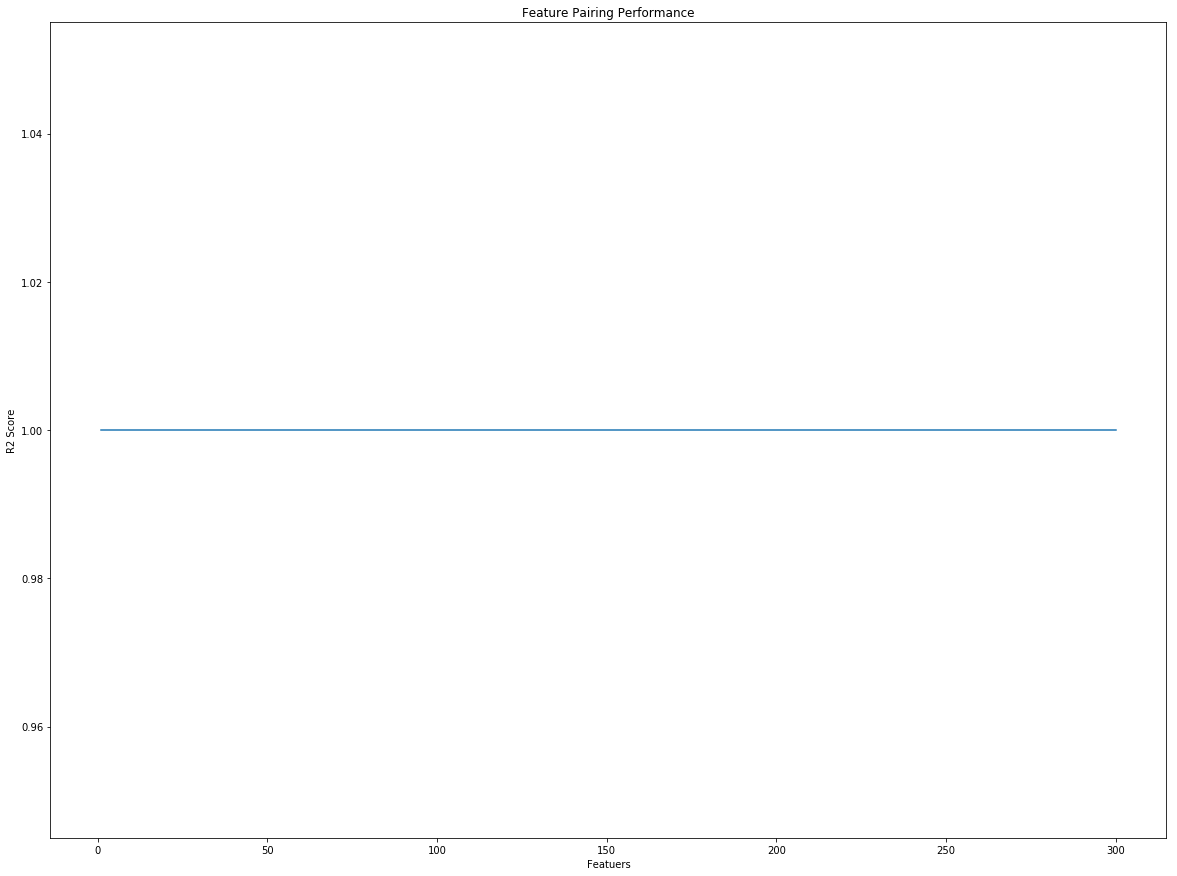

In [40]:
rfr_hist_sysstat_score, rfr_hist_sysstat_count = EnsembleWrappers.rfr_wrapper(X_df=rep_hist_sysstat_df_pruned_norm,
                                                                              y_df=y_labels,
                                                                              test_split=test_split,
                                                                              table_name='REP_HIST_SYSSTAT',
                                                                              top_n_features=top_n_features,
                                                                              parallel_degree=parallel_degree)

### Gradient Boosting Wrapper (Feature Combination)  (Regression)

Utilizes an ensemble Gradient Boosting method to gauge different feature combination/counts.

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

Table [REP_HIST_SYSSTAT] RFR R2 Score: 0.0
Feature Importance
------------------------------------------------------------
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.24659049e-01
 0.00000000e+00 1.88408098e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.46712205e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.78687676e-05 1.44737018e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.64116167e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.17888020e-02 0.00000000e+00 0.00000000e+00
 2.17242500e-06 8.05432323e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.81087108e-05 0.00000000e+00 0.00000000e+00 3.36232388e-05
 4.21634793e-04 2.68200616e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000

Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0, n=300, R2 Score: 0.0
Thresh=0.0

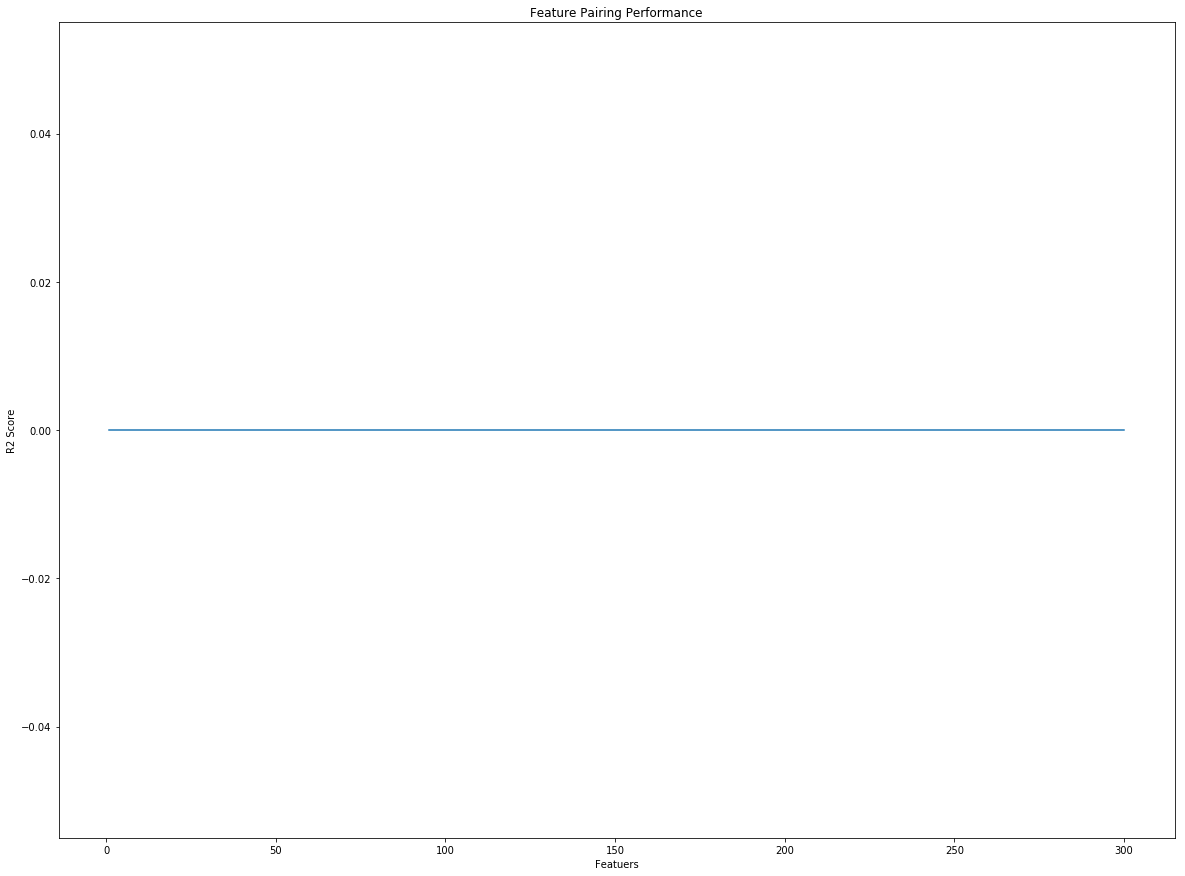

In [41]:
gbw_hist_sysstat_score, gbw_hist_sysstat_count = EnsembleWrappers.gradient_boosting_wrapper(X_df=rep_hist_sysstat_df_pruned_norm,
                                                                                            y_df=y_labels,
                                                                                            test_split=test_split,
                                                                                            table_name='REP_HIST_SYSSTAT',
                                                                                            top_n_features=top_n_features)

### Recursive Feature Elimination (Regression)

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [42]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, model=None, parallel_degree=1):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df.values
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
        print(X_train.shape)
        print(X_test.shape)
        print(y_train.shape)
        print(y_test.shape)
        if model == 0:
            model = RandomForestRegressor(n_estimators=X_df.shape[1]*10,  # Use 10* the number of features
                                          n_jobs=parallel_degree)
        elif model == 1:
            model = GradientBoostingRegressor(n_estimators=X_df.shape[1]*10)  # Use 10* the number of features

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]

In [43]:
if rfr_hist_sysstat_score > gbw_hist_sysstat_score:
    rep_hist_sysstat_op = rfr_hist_sysstat_count
    rep_hist_sysstat_model = 0
else:
    rep_hist_sysstat_op = gbw_hist_sysstat_count
    rep_hist_sysstat_model = 1

print('Recommended Feature Drop [' + str(rep_hist_sysstat_op) + '] using model [' + str(rep_hist_sysstat_model) + ']')
fe = FeatureEliminator(X_df=rep_hist_sysstat_df_pruned_norm,
                       y_df=y_labels)
column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
                                               optimum_feature_count=rep_hist_sysstat_op,
                                               model = rep_hist_sysstat_model,
                                               parallel_degree=parallel_degree)
print(rep_hist_sysstat_df_pruned_norm.columns)
rep_hist_sysstat_df_pruned_norm = fe.get_selected_features(column_mask=column_mask)
print(rep_hist_sysstat_df_pruned_norm.columns)

Recommended Feature Drop [300] using model [0]
(2, 300)
(1, 300)
(2,)
(1,)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True 

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

STAT_NAME  BATCHED IO (BOUND) VECTOR COUNT  BATCHED IO (FULL) VECTOR COUNT  \
0                                      0.0                             0.0   
1                                      1.0                             1.0   
2                                      1.0                             1.0   

STAT_NAME  BATCHED IO (SPACE) VECTOR COUNT  BATCHED IO BLOCK MISS COUNT  \
0                                      0.0                     0.000000   
1                                      0.0                     0.999751   
2                                      0.0                     1.000000   

STAT_NAME  BATCHED IO BUFFER DEFRAG COUNT  BATCHED IO DOUBLE MISS COUNT  \
0                                     0.0                      0.000000   
1                                     1.0                      0.999702   
2                                     1.0                      1.000000   

STAT_NAME  BATCHED IO SAME UNIT COUNT  BATCHED IO SINGLE BLOCK COUNT  \
0            

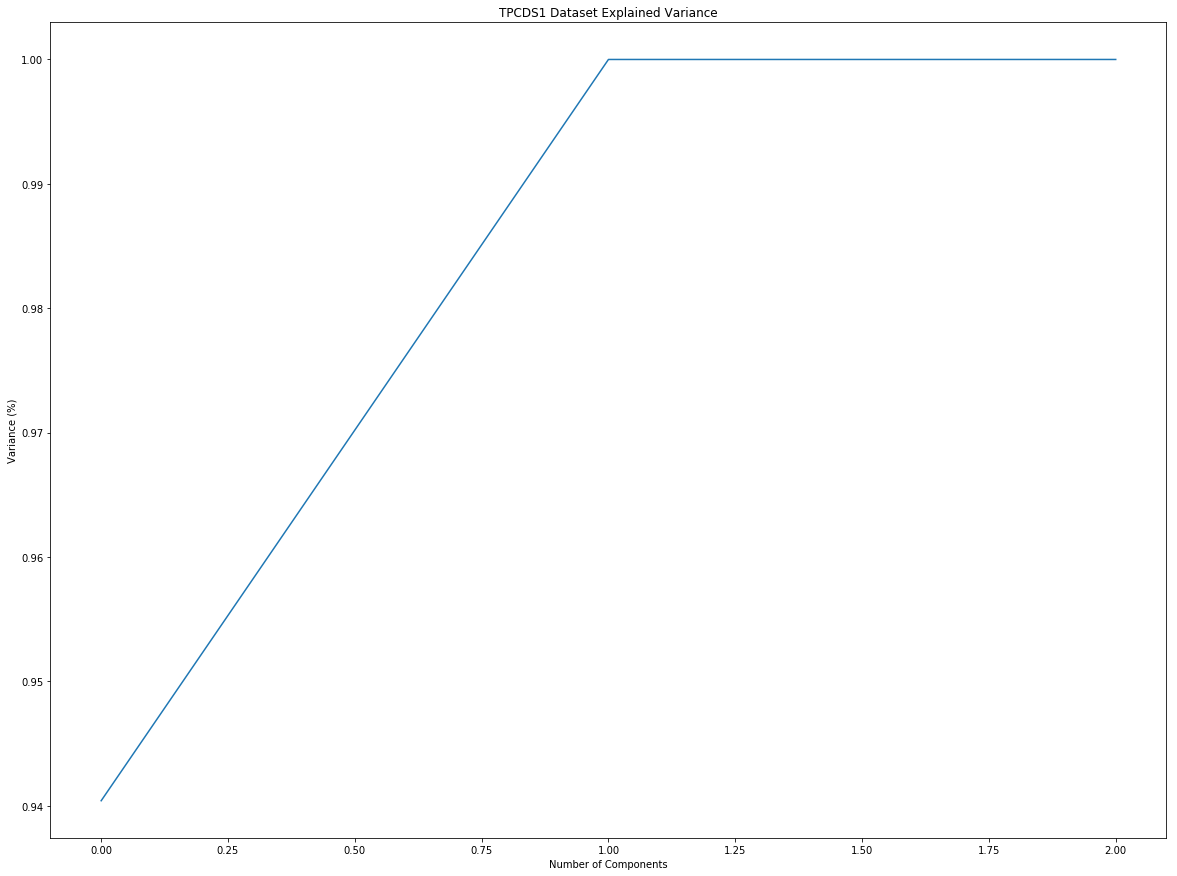

------------------------------
   Component_0
0     9.708016
1    -3.334631
2    -6.373386
(3, 1)


In [44]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(rep_hist_sysstat_df_pruned_norm.head())
print(rep_hist_sysstat_df_pruned_norm.shape)

pcac = PrincipalComponentAnalysisClass(X_df=rep_hist_sysstat_df_pruned_norm)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
rep_hist_sysstat_df_pruned_norm = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(rep_hist_sysstat_df_pruned_norm.head())
print(rep_hist_sysstat_df_pruned_norm.shape)